In [102]:
import pandas as pd
import ast
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
import numpy as np
from joblib import Parallel, delayed
warnings.filterwarnings("ignore")

In [134]:
df = pd.read_csv("movies.csv")
df = df.dropna()
df = df.to_dict(orient="records")
out = {"items": df}

import json

with open("sample-input-for-clustering-nonulls.json", 'w') as fp:
    json.dump(out, fp)

### actual clustering

In [94]:
df_orig = pd.read_csv("movies.csv")
df = df_orig

# In case the dataframe was not saved properly I want this removed
if "Unnamed: 0" in df.columns:
    df = df.drop("Unnamed: 0", axis=1)
    
# Keep columns of interest
df = df[['id', 'budget', 'popularity', 'revenue', 'runtime',
                 'vote_average', 'vote_count', 'categories']]

# Fill missing values in runtime
df['runtime'] = df['runtime'].fillna((df['runtime'].mean()))

In [95]:
# Clean the categories column
df['categories'] = df['categories'].apply(ast.literal_eval)
df['categories'] = df['categories'].apply(lambda x: [i['name'] for i in x])

In [96]:
# One hot encode categories
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['categories'])
df = df.join(pd.DataFrame(X, columns=mlb.classes_))
df = df.drop('categories', axis=1)

In [97]:
# Normalize the data (data is not normally distributed)
minmaxed_df = preprocessing.MinMaxScaler().fit_transform(df.drop('id',axis=1))
scaled_df = pd.DataFrame(minmaxed_df, index=df.index, columns=df.columns[1:])

In [98]:
scaled_df.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western'],
      dtype='object')

In [77]:
# Apply k-means clustering
num_clusters = range(2, 15)
kmeans = [KMeans(n_clusters=i, random_state=42) for i in num_clusters]
score = [kmeans[i].fit(scaled_df).score(scaled_df) for i in range(len(kmeans))]

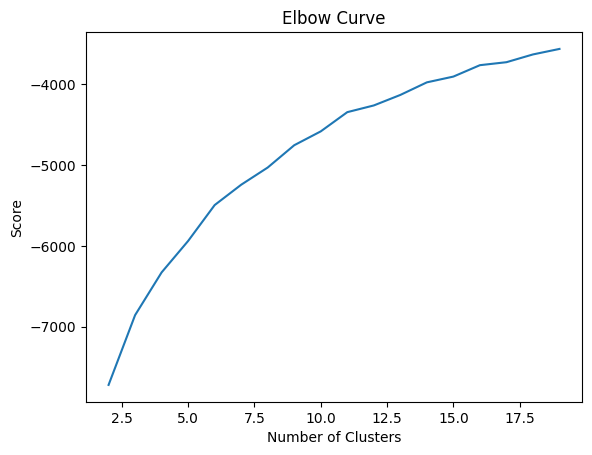

In [7]:
plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [80]:
from sklearn.metrics import silhouette_score

num_clusters = range(2, 15)
kmeans = [KMeans(n_clusters=i, random_state=42) for i in num_clusters]
silhouette_scores = [silhouette_score(scaled_df, kmeans[i].fit(scaled_df).labels_) for i in range(len(kmeans))]

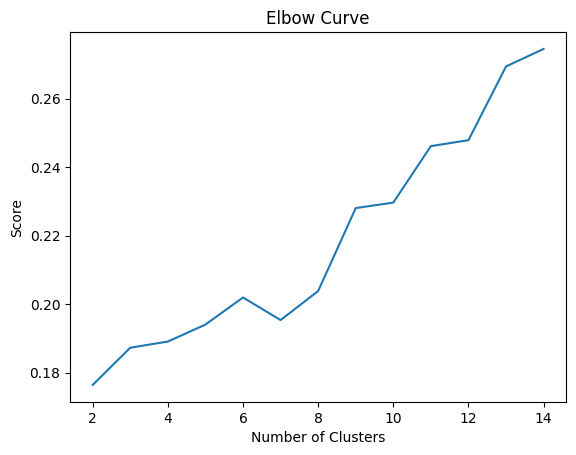

In [81]:
plt.plot(num_clusters, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [82]:
# Now fit for the ideal number of clusters
kmeans_model = KMeans(n_clusters=7)
kmeans_model.fit(scaled_df)

KMeans(n_clusters=7)

In [83]:
# Assign the cluster labels to the original df
df_orig['cluster'] = kmeans_model.labels_

In [84]:
df_orig.head()

,adult,belongs_to_collection,budget,categories,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cluster
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,2
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,5
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,2
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,2


In [85]:
df_orig.cluster.value_counts()

2    1355
3     931
0     745
6     562
4     515
5     452
1     440
Name: cluster, dtype: int64

In [89]:
# Save the model
with open("7-means-clustering.pkl", "wb") as f:
    pickle.dump(kmeans_model, f)

In [46]:
# Load the model
with open("7-means-clustering.pkl", "rb") as f:
    kmeans_model = pickle.load(f)

### How to read the responses

In [101]:
import json

# Opening JSON file
f = open("sample_response_to_predict.json")

# returns JSON object as
# a dictionary
data1 = json.load(f)

#converting it into dataframe
df = pd.read_json(data1, orient ='records')

df

,adult,belongs_to_collection,budget,categories,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cluster
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,null,Toy Story,False,7.7,5415,5
1,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,null,Toy Story,False,7.7,5415,5


In [139]:
import json

# Opening JSON file
f = open("sample_response_to_cluster.json")

# returns JSON object as
# a dictionary
data1 = json.load(f)

#converting it into dataframe
df = pd.read_json(data1, orient ='records')

df.head()

,adult,belongs_to_collection,budget,categories,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cluster
0,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,352194034,130,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194,3
1,False,"{'id': 43563, 'name': 'Friday Collection', 'po...",3500000,"[{'id': 35, 'name': 'Comedy'}]",http://www.newline.com/properties/friday.html,10634,tt0113118,en,Friday,Craig and Smokey are two guys in Los Angeles h...,...,28215918,91,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A lot can go down between thursday and saturda...,Friday,False,7.0,513,4
2,False,"{'id': 10924, 'name': 'From Dusk Till Dawn Col...",19000000,"[{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...",http://www.miramax.com/movie/from-dusk-till-dawn/,755,tt0116367,en,From Dusk Till Dawn,Seth Gecko and his younger brother Richard are...,...,25836616,108,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,One night is all that stands between them and ...,From Dusk Till Dawn,False,6.9,1644,6
3,False,"{'id': 439053, 'name': 'Brooklyn Cigar Store C...",2000000,"[{'id': 35, 'name': 'Comedy'}]",http://miramax.com/movie/blue-in-the-face/,5894,tt0112541,en,Blue in the Face,"Auggie runs a small tobacco shop in Brooklyn, ...",...,1275000,83,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Welcome to the planet Brooklyn.,Blue in the Face,False,6.8,28,4
4,False,"{'id': 286162, 'name': 'Power Rangers Collecti...",15000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.powerrangers.com/,9070,tt0113820,en,Mighty Morphin Power Rangers: The Movie,Power up with six incredible teens who out-man...,...,66000000,92,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Power Is On!,Mighty Morphin Power Rangers: The Movie,False,5.2,153,1
